# Identify tumor regions on Slide-tags data.



In this tutorial, we foucs on the Slide-tags human melanoma data. The raw data and processed data are available at [Google Drive](https://drive.google.com/drive/folders/1rAAbJcpMbXLz8eqNsPCE90pa9DpdijjH?usp=sharing). 

In [3]:

import scanpy as sc
import matplotlib.pyplot as plt
import MultiGATE 

## Preparation

### Load RNA data

In [4]:

base_path = './output/'


file_name= "../data_tutorial/slide_tags/HumanMelanoma_RNA.h5ad" #RNA
adata1 = sc.read_h5ad(file_name)
adata1


AnnData object with n_obs × n_vars = 2535 × 14807
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'spatial'

In [ ]:

adata1.obsm["spatial"] = adata1.obsm["spatial"]*(-1)
MultiGATE.Cal_Spatial_Net(adata1, rad_cutoff=100) 
MultiGATE.Stats_Spatial_Net(adata1)



### Load ATAC data

In [5]:


file_name= "../data_tutorial/slide_tags/HumanMelanoma_ATAC_lsi.h5ad" #ATAC  
adata2 = sc.read_h5ad(file_name)
adata2


AnnData object with n_obs × n_vars = 2535 × 13665
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'spatial'

In [ ]:

adata2.obsm["spatial"] = adata2.obsm["spatial"]*(-1)
MultiGATE.Cal_Spatial_Net(adata2, rad_cutoff=100)
MultiGATE.Stats_Spatial_Net(adata2)

adata1 = adata1[:, adata1.var['highly_variable']]
adata2 = adata2[:, adata2.var['highly_variable']]

MultiGATE.Cal_gene_peak_Net_new(adata1, adata2, 150000,file = '../data_tutorial/human/gencode.v25.chr_patch_hapl_scaff.annotation.gtf.gz')
adata1.uns['gene_peak_Net'] = adata2.uns['gene_peak_Net']


## Running MultiGATE

In [3]:
num_epoch = 3000 
adata1, adata2 = MultiGATE.train_MultiGATE(adata1, adata2, bp_width = 400,n_epochs=num_epoch,save_attention=True) 

Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2024-04-16 14:11:10.190897: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-04-16 14:11:10.197912: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3100000000 Hz
2024-04-16 14:11:10.198539: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560e17133cb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-04-16 14:11:10.198568: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-04-16 14:11:10.201715: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-04-16 14:11:11.305226: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560e1719c340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-16 14:11:11.305275: I tensorflow/compil

## Clustering

In [6]:
size = 10
resolution =  0.1 
sc.pp.neighbors(adata1, use_rep='MultiGATE_clip_all',key_added = 'avg') 
sc.tl.louvain(adata1, resolution=resolution,neighbors_key = 'avg')

## Plotting the results

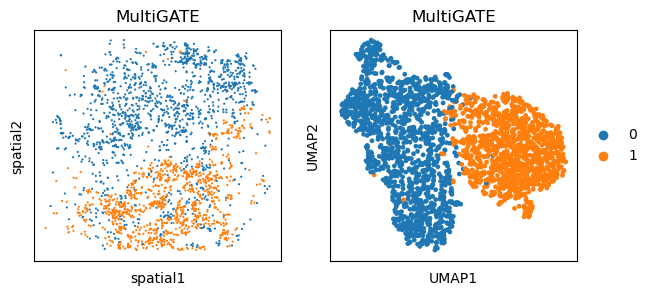

In [7]:

plt.rcParams["figure.figsize"] = (7, 3) 
fig, axs = plt.subplots(1, 2)
sc.tl.umap(adata1,neighbors_key = 'avg',)
sc.pl.embedding(adata1, basis="spatial", color="louvain",s=size, show=False, title='MultiGATE',ax=axs[0],legend_loc=None)
sc.pl.umap(adata1, color="louvain",title='MultiGATE',ax=axs[1])
